<div style="text-align:center; font-size:2.5em; color:#4B0055; letter-spacing:2px; background-color:#F5F5F5; padding:20px; border-radius:10px; width: 97%">
    Teste A/B: 
    <span style="color:#FFA726; font-weight:bold;">Fluxar</span>
    <div style="text-align:center; margin-top:10px;">
        <img src="logo_fluxar.png" alt="Logo Fluxar" style="height:70px;">
    </div>
</div>


<div style="background:#F7F3FF; border-left:8px solid #4B0055; padding:16px; margin-top:20px; width: 97%">
    <span style="font-size:1.3em; color:#4B0055; font-weight:bold;">Objetivo do Notebook:</span><br>
    <span style="color:#FFA726; font-size:1.1em;">Validar Teste A/B do Excel — <b>Fluxar</b></span>
</div>

<div style="background:linear-gradient(90deg, #FFA726 0%, #FF1493 100%); color:white; padding:18px; border-radius:10px; margin-top:20px; width:97%;">
    <span style="font-size:1.2em; font-weight:bold;">Objetivos da Análise do Teste A/B:</span>
    <ul style="margin-top:10px;">
        <li>Comparar o desempenho entre as versões <b>Teste A</b> e <b>Teste B</b> do sistema Fluxar.</li>
        <li>Verificar se há <b>diferença estatisticamente significativa</b> no tempo de execução das ações <b>“Adicionar lote”</b> e <b>“Deletar lote”</b>.</li>
        <li>Aplicar o <b>teste t de Student</b> (nível de confiança de 95%) para avaliar a hipótese de que o <b>Teste B é mais eficiente</b>.</li>
        <li>Detectar e analisar <b>outliers</b> que possam influenciar nos resultados de desempenho.</li>
        <li>Gerar evidências quantitativas que validem ou refutem a melhoria proposta na nova versão do sistema.</li>
    </ul>
</div>


<!-- Etapa 1 -->
<div style="background:#F7F3FF; border-left:8px solid #FFA726; padding:18px; border-radius:10px; margin-top:24px; width: 97%">
  <span style="font-size:1.2em; color:#4B0055; font-weight:bold;">1. Importação de Bibliotecas e Criação dos Datasets</span>
  <ul style="color:#4B0055; margin-top:12px;">
    <li>Importar bibliotecas essenciais: pandas, math, numpy, os, etc.</li>
    <li>Importar bibliotecas do Teste-T: <code>spicy.stats</code> e <code>pingouin</code></li>
    <li>Carregar o dataset de inventário diretamente do KaggleHub.</li>
    <li>Visualizar as primeiras linhas para entender colunas, tipos de dados e valores gerais.</li>
  </ul>
</div>

Importando bibliotecas

In [206]:
import pandas as pd
from scipy.stats import ttest_ind, t as t_dist
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt, ceil, floor
import numpy as np
import os
from IPython.display import display, HTML
from matplotlib.patches import FancyBboxPatch

Criando datasets com base nos dados do Excel

In [135]:
# Base de dados
dados = pd.DataFrame([
    [1,'B','May/Helo','Elma Junia',27,84,5],
    [2,'B','May/Helo','Márcio Wada',48,53,14],
    [3,'B','May/Helo','Gabriela',20,6,13],
    [4,'B','May/Helo','Paulo Henrique',29,2,13],
    [5,'B','May/Helo','Gil Oliveira',47,7,7],
    [6,'B','May/Helo','Gabriel',28,6,11],
    [7,'A','Nat/duda','Lucas',30,60,45],
    [8,'A','Lelê/Helo','Victor',34,5,6],
    [9,'A','Nat/duda','Renato',44,71,60],
    [10,'B','Diogo/Gi','Julia Czank',17,25,12],
    [11,'B','Diogo/Gi','Matheus Santiago',19,65,107],
    [12,'A','Nat/duda','Solange',43,130,25],
    [13,'B','Diogo/Gi','Laricia',32,21,7],
    [14,'A','Nat/duda','Bruno',32,10,15],
    [15,'B','Diogo/Gi','Alex Gabriel',23,15,5],
    [16,'B','Diogo/Gi','Karina',36,9,13],
    [17,'B','Diogo/Gi','Natanie',25,8,4],
    [18,'B','Diogo/Gi','Marilucia',43,46,14],
    [19,'A','Lelê/Helo','Jaqueline',31,150,60],
    [20,'A','Lelê/Helo','Alex',35,120,90],
    [21,'A','Lelê/Helo','Matheus',42,45,20],
    [22,'A','Lelê','David',27,20,15],
    [23,'A','Lelê','Roberto',58,50,30],
    [24,'B','Lelê','Márcio',48,40,10],
], columns=['ID','Teste','Aplicador(es)','Nome','Idade','Adicionar lote','Deletar lote'])

# Garante que as pastas existem
os.makedirs("dados/adicionar", exist_ok=True)
os.makedirs("dados/deletar", exist_ok=True)

# Filtra e salva os CSVs
for teste in ['A', 'B']:
    df_add = dados[dados['Teste'] == teste][['ID','Teste','Aplicador(es)','Nome','Idade','Adicionar lote']]
    df_del = dados[dados['Teste'] == teste][['ID','Teste','Aplicador(es)','Nome','Idade','Deletar lote']]
    
    df_add.to_csv(f'dados/adicionar/{teste}.csv', index=False, encoding='utf-8-sig')
    df_del.to_csv(f'dados/deletar/{teste}.csv', index=False, encoding='utf-8-sig')

print("✅ CSVs gerados com sucesso!")


✅ CSVs gerados com sucesso!


Criação de função para visualização de tabelas

In [136]:
def estilizar_tabela(df, 
                     header_color='#FFA726', 
                     header_text_color='white', 
                     cell_padding='5px', 
                     text_align='left', 
                     font_size='12px'):
    """
    Aplica um estilo padronizado às tabelas pandas DataFrame para exibição bonita em notebooks.

    Parâmetros:
    - df: DataFrame -> Tabela a ser estilizada.
    - header_color: str -> Cor de fundo do cabeçalho.
    - header_text_color: str -> Cor do texto do cabeçalho.
    - cell_padding: str -> Espaçamento interno das células.
    - text_align: str -> Alinhamento do texto ('left', 'center', 'right').
    - font_size: str -> Tamanho da fonte.
    
    Retorno:
    - DataFrame estilizado pronto para exibição com display().
    """
    
    styled = (
        df.style.set_table_styles([
            {'selector': 'th',
             'props': [
                 ('background-color', header_color),
                 ('color', header_text_color),
                 ('font-weight', 'bold'),
                 ('text-align', 'center'),
                 ('font-size', font_size)
             ]},
            {'selector': 'td',
             'props': [
                 ('padding', cell_padding),
                 ('text-align', text_align),
                 ('font-size', font_size)
             ]}
        ])
    )
    
    return styled


<!-- Etapa 2 Principal -->
<div style="background:#F7F3FF; border-left:8px solid #FFA726; padding:18px; border-radius:10px; margin-top:24px; width: 97%">
  <span style="font-size:1.3em; color:#4B0055; font-weight:bold;">2. Limpeza e Análise Inicial</span>
  <p style="color:#4B0055; margin-top:10px;">
    Nessa etapa:
  </p>
  <ul style="color:#4B0055; margin-top:10px;">
    <li>Importamos os datasets salvos.</li>
    <li>Armazenamos em df's com nomes explicativos.</li>
    <li>Olhamos os df's crus e como os dados se apresentam.</li>
    <li>Fazemos um describe para ver dados estatísticos gerais dos df's.</li>
  </ul>
</div>


Lê os arquivos e salva em df's

In [137]:
# Lê os CSVs de "adicionar"
df_adicionar_A = pd.read_csv("dados/adicionar/A.csv")
df_adicionar_B = pd.read_csv("dados/adicionar/B.csv")

# Lê os CSVs de "deletar"
df_deletar_A = pd.read_csv("dados/deletar/A.csv")
df_deletar_B = pd.read_csv("dados/deletar/B.csv")

Basicamente mostra o conteúdo de cada df. A diferença é que para visualizar um do lado do outro e comparar melhor usamos a lib HTML do IPython   

In [164]:
html_titulo = f"""
<div style='display:flex; justify-content:center; align-items:flex-start; gap:40px; margin-top:10px; flex-wrap:wrap;'>
    <h1 style='color:#4B0055'>Conteúdo dos datasets</h1>
</div>
"""

html_todas = f"""
<div style='display:flex; gap:20px; justify-content:space-between; flex-wrap:nowrap; overflow-x:auto;'>
    <div style='flex:1;'>{estilizar_tabela(df_adicionar_A)._repr_html_()}</div>
    <div style='flex:1;'>{estilizar_tabela(df_deletar_A)._repr_html_()}</div>
    <div style='flex:1;'>{estilizar_tabela(df_adicionar_B)._repr_html_()}</div>
    <div style='flex:1;'>{estilizar_tabela(df_deletar_B)._repr_html_()}</div>
</div>
"""
display(HTML(html_titulo))
display(HTML(html_todas))


,ID,Teste,Aplicador(es),Nome,Idade,Adicionar lote
0,7,A,Nat/duda,Lucas,30,60
1,8,A,Lelê/Helo,Victor,34,5
2,9,A,Nat/duda,Renato,44,71
3,12,A,Nat/duda,Solange,43,130
4,14,A,Nat/duda,Bruno,32,10
5,19,A,Lelê/Helo,Jaqueline,31,150
6,20,A,Lelê/Helo,Alex,35,120
7,21,A,Lelê/Helo,Matheus,42,45
8,22,A,Lelê,David,27,20
9,23,A,Lelê,Roberto,58,50


In [175]:
# Cria DataFrames equivalentes de "tempo total"
df_tempo_total_A = df_adicionar_A.copy()
df_tempo_total_A["Tempo total"] = df_adicionar_A["Adicionar lote"] + df_deletar_A["Deletar lote"]

df_tempo_total_B = df_adicionar_B.copy()
df_tempo_total_B["Tempo total"] = df_adicionar_B["Adicionar lote"] + df_deletar_B["Deletar lote"]

# Estatísticas descritivas
html_titulo = f"""
<div style='display:flex; justify-content:center; align-items:flex-start; gap:40px; margin-top:5px; flex-wrap:wrap'>
    <h1 style='color:#4B0055'>Estatísticas Descritivas - Tempo Total</h1>
</div>
"""
html_tempo_total = f"""
<div style='display:flex; justify-content:center; align-items:flex-start; gap:40px; margin-top:1px; flex-wrap:wrap;'>
    <div style='flex:0 1 10%; max-width:30%; text-align:center;'>
        <h4 style='color:#FF6F00; margin-bottom:8px;'>Teste A — Tempo total</h4>
        {estilizar_tabela(df_tempo_total_A[["Tempo total"]].describe())._repr_html_()}
    </div>
    <div style='flex:0 1 10%; max-width:90%; text-align:center;'>
        <h4 style='color:#D81B60; margin-bottom:8px;'>Teste B — Tempo total</h4>
        {estilizar_tabela(df_tempo_total_B[["Tempo total"]].describe())._repr_html_()}
    </div>
</div>
"""
display(HTML(html_titulo))
display(HTML(html_tempo_total))

,Tempo total
count,10.000000
mean,102.700000
std,72.674388
min,11.000000
25%,42.500000
50%,92.500000
75%,149.000000
max,210.000000
,Tempo total
count,14.000000


<!-- Etapa 3 -->
<div style="background:#F7F3FF; border-left:8px solid #FFA726; padding:18px; border-radius:10px; margin-top:24px; width: 97%">
  <span style="font-size:1.3em; color:#4B0055; font-weight:bold;">3. Outliers</span>
  <p style="color:#4B0055; margin-top:10px;">
    Nessa etapa:
  </p>
  <ul style="color:#4B0055; margin-top:10px;">
    <li>Verificar outliers em ambos os testes. Caso tenha, aparece na tabela.</li>
    <li>Visualizar os boxplots dos outliers dos testes A e B.</li>
  </ul>
</div>


,ID,Teste,Aplicador(es),Nome,Idade,Adicionar lote
,ID,Teste,Aplicador(es),Nome,Idade,Adicionar lote


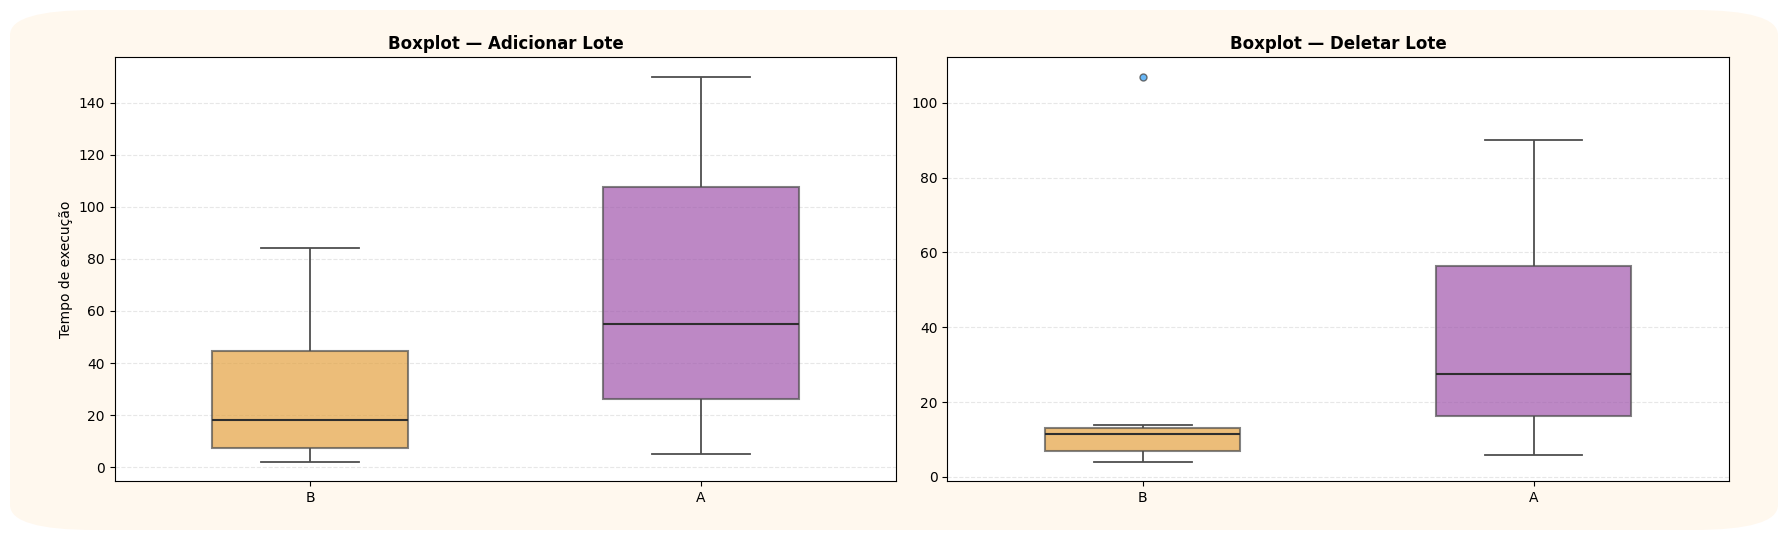

In [179]:
# Função para identificar outliers com base no IQR 
def detectar_outliers(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    return df[(df[coluna] < limite_inferior) | (df[coluna] > limite_superior)]

# Detecta outliers
outliers_A_add = detectar_outliers(df_adicionar_A, "Adicionar lote")
outliers_B_add = detectar_outliers(df_adicionar_B, "Adicionar lote")

# =======================================================================================
# Tabelas de Outliers

# Ajuste de padding
styled_A = estilizar_tabela(outliers_A_add).set_table_styles([
    {'selector':'th', 'props':[('padding','5px 20px 10px 30px')]}, 
    {'selector':'td', 'props':[('padding','5px 20px 10px 20px')]}  
])

styled_B = estilizar_tabela(outliers_B_add).set_table_styles([
    {'selector':'th', 'props':[('padding','5px 20px 10px 30px')]},
    {'selector':'td', 'props':[('padding','5px 20px 10px 20px')]}
])

# HTML com tabelas estilizadas
html_outliers = f"""
<div style='display:flex; gap:30px; align-items:flex-start; margin-top:20px; 
            background: linear-gradient(90deg, #FFF3E0 0%, #F3E5F5 100%); 
            padding:30px; border-radius:12px;'>

    <div style='flex:1; text-align:center;'>
        <h4 style='color:#FF6F00'>🔸 Outliers - Teste A</h4>
        {styled_A._repr_html_()}
    </div>

    <div style='flex:1; text-align:center;'>
        <h4 style='color:#AB47BC;'>🔹 Outliers - Teste B</h4>
        {styled_B._repr_html_()}
    </div>

</div>
"""


display(HTML(html_outliers))
plt.show()

# =======================================================================================
# Boxplot

# Configuração dos outliers (bolinhas)
flierprops = dict(marker='o', markerfacecolor='#42A5F5', markersize=5, linestyle='none', alpha=0.8)

# Paleta Fluxar
fluxar_palette = ["#FFA726", "#AB47BC"]

# Criar figura com 2 eixos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(17,5))  # 1 linha, 2 colunas

# Fundo arredondado e transparente do gráfico (abrange toda a figura)
bbox = FancyBboxPatch(
    (0,0), 1,1,
    boxstyle="round,pad=0.02,rounding_size=0.05",
    transform=fig.transFigure,
    facecolor=(1.0,0.91,0.78,0.3),
    edgecolor="none",
    zorder=-1
)
fig.patches.append(bbox)

# Boxplot Adicionar lote
sns.boxplot(
    data=dados,
    x="Teste",
    y="Adicionar lote",
    palette=fluxar_palette,
    width=0.5,
    linewidth=1.5,
    fliersize=5,
    flierprops=flierprops,
    boxprops=dict(alpha=0.7),
    medianprops=dict(color="#2E2E2E", linewidth=1.5),
    whiskerprops=dict(linewidth=1.3),
    capprops=dict(linewidth=1.3),
    ax=axes[0],
    hue="Teste",
)
axes[0].set_title("Boxplot — Adicionar Lote", fontsize=12, fontweight='bold')
axes[0].set_xlabel("")
axes[0].set_ylabel("Tempo de execução")
axes[0].grid(axis="y", linestyle="--", alpha=0.3)

# Boxplot Deletar lote
sns.boxplot(
    data=dados,
    x="Teste",
    y="Deletar lote",
    palette=fluxar_palette,
    width=0.5,
    linewidth=1.5,
    fliersize=5,
    flierprops=flierprops,
    boxprops=dict(alpha=0.7),
    medianprops=dict(color="#2E2E2E", linewidth=1.5),
    whiskerprops=dict(linewidth=1.3),
    capprops=dict(linewidth=1.3),
    ax=axes[1],
    hue="Teste",
)
axes[1].set_title("Boxplot — Deletar Lote", fontsize=12, fontweight='bold')
axes[1].set_xlabel("")
axes[1].set_ylabel("")
axes[1].grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

<!-- Etapa 4 -->
<div style="background:#F7F3FF; border-left:8px solid #FFA726; padding:18px; border-radius:10px; margin-top:24px; width: 97%">
  <span style="font-size:1.3em; color:#4B0055; font-weight:bold;">4. Testes-T</span>
  <p style="color:#4B0055; margin-top:10px;">
    <bold>Objetivo:</bold> Avaliar se o Teste B é mais eficiente (ou seja, um menor tempo) que o Teste A nas tarefas "Adicionar lote" e "Deletar lote".
  </p>
</div>


In [200]:
# Função utilitária para exibir resultados formatados
def mostrar_resultado_teste(nome_tarefa, resultado):
    """
    Mostra o resultado formatado e estilizado de um teste t independente.
    Inclui gradiente, cantos arredondados e layout centralizado.
    """

    # Extrair p-valor de forma segura
    p_valor = resultado["p-val"].iloc[0]

    # Determinar mensagem e cor de destaque
    if p_valor < 0.05:
        mensagem = f"- Há diferença significativa — o Teste B foi mais eficiente (menor tempo em {nome_tarefa.lower()})."
        cor_msg = "#2E7D32"  # verde
    else:
        mensagem = f"- Não há diferença significativa no tempo de {nome_tarefa.lower()} entre A e B."
        cor_msg = "#424242"  # cinza escuro

    # HTML estilizado com gradiente e cantos arredondados
    estilo_html = f"""
    <div style="
        font-family: 'Poppins', 'Segoe UI';
        background: linear-gradient(90deg, #FFF3E0 0%, #F3E5F5 100%); 
        border-radius: 16px;
        padding: 22px 28px;
        margin: 18px 0;
        text-align: center;
        box-shadow: 0 2px 8px rgba(0,0,0,0.08);
    ">
        <h3 style="color:#FF6F00; margin-bottom:10px; font-weight:600;">
            Resultado Teste T — {nome_tarefa}
        </h3>
        <div style="display:flex; justify-content:center; align-items:center; text-align:center;">
            {estilizar_tabela(resultado[["T", "p-val", "dof"]])._repr_html_()}
        </div>
        <p style="color:{cor_msg}; margin-top:12px; font-size:15px;">
            {mensagem}
        </p>
    </div>
    """

    display(HTML(estilo_html))
# ==========================================================
# Teste t para ADICIONAR LOTE
# ==========================================================
tempo_a_add = df_adicionar_A["Adicionar lote"]
tempo_b_add = df_adicionar_B["Adicionar lote"]

# Teste t unilateral: H₀ = médias iguais, H₁ = B < A (B mais rápido)
result_add = pg.ttest(
    tempo_b_add, tempo_a_add,
    paired=False,       # Amostras independentes
    alternative="less", # Teste unilateral (B < A)
    correction=True     # Correção de Welch para variâncias desiguais
)

mostrar_resultado_teste("Adicionar Lote", result_add)


# ==========================================================
# Teste t para DELETAR LOTE
# ==========================================================
tempo_a_del = df_deletar_A["Deletar lote"]
tempo_b_del = df_deletar_B["Deletar lote"]

result_del = pg.ttest(
    tempo_b_del, tempo_a_del,
    paired=False,
    alternative="less",
    correction=True
)

mostrar_resultado_teste("Deletar Lote", result_del)

# ==========================================================
# Teste t — TEMPO TOTAL (Adicionar + Deletar)
# ==========================================================
# Soma dos tempos por participante (A e B)
tempo_total_a = df_adicionar_A["Adicionar lote"] + df_deletar_A["Deletar lote"]
tempo_total_b = df_adicionar_B["Adicionar lote"] + df_deletar_B["Deletar lote"]

# Teste t unilateral: H₀ = médias iguais, H₁ = B < A (B mais rápido no total)
result_total = pg.ttest(
    tempo_total_b, tempo_total_a,
    paired=False,
    alternative="less",
    correction=True
)

mostrar_resultado_teste("Tempo Total (Adicionar + Deletar)", result_total)


,T,p-val,dof
T-test,-2.176979,0.024854,12.259044


,T,p-val,dof
T-test,-1.812358,0.042722,19.392115


,T,p-val,dof
T-test,-2.261483,0.020343,13.599942


<!-- Etapa 5 -->
<div style="background:#F7F3FF; border-left:8px solid #FFA726; padding:18px; border-radius:10px; margin-top:24px; width: 97%">
  <span style="font-size:1.3em; color:#4B0055; font-weight:bold;">5. Testes-T Manual</span>
  <p style="color:#4B0055; margin-top:10px;">
    <bold>Objetivo:</bold> O mesmo do útlimo, dessa vez fazendo mais detalhado e explicativo.
  </p>
</div>


In [ ]:
# Função utilitária para exibir resultados com gradiente
def mostrar_resultado_teste_gradiente(nome_tarefa, media_a, media_b, var_a, var_b, n_a, n_b):
    """Calcula o teste t independente manualmente e exibe com estilo gradiente."""
    
    # Cálculo do t-test
    t_test = (media_a - media_b) / sqrt((var_a / n_a) + (var_b / n_b))
    baixo_df = ((var_a / n_a) ** 2) / (n_a - 1) + ((var_b / n_b) ** 2) / (n_b - 1)
    df = ((var_a / n_a + var_b / n_b) ** 2) / baixo_df

    # Mensagem de interpretação
    if t_test > 0:
        cor_msg = "#FF6F00"
        mensagem = f"- Teste B foi mais eficiente (menor tempo em {nome_tarefa.lower()})"
    else:
        cor_msg = "#AB47BC"
        mensagem = f"- Não há diferença significativa no tempo de {nome_tarefa.lower()} entre A e B"

    # HTML estilizado
    estilo_html = f"""
    <div style="
        font-family: 'Poppins', 'Segoe UI';
        background: linear-gradient(90deg, #FFF3E0 0%, #F3E5F5 100%); 
        border-radius: 16px;
        padding: 22px 28px;
        margin: 18px 0;
        text-align: center;
        box-shadow: 0 2px 8px rgba(0,0,0,0.08);
    ">
        <h3 style="color:#FF6F00; margin-bottom:10px; font-weight:600;">
            Resultado Teste T — {nome_tarefa}
        </h3>
        <div style="text-align:center; margin-bottom:12px;">
            <table style="margin:auto; border-collapse: collapse;">
                <tr><th style="padding:8px 15px;">Média A</th><th style="padding:8px 15px;">Média B</th>
                    <th style="padding:8px 15px;">Variância A</th><th style="padding:8px 15px;">Variância B</th>
                    <th style="padding:8px 15px;">t-test</th><th style="padding:8px 15px;">df</th></tr>
                <tr style="text-align:center;">
                    <td>{media_a:.2f}</td>
                    <td>{media_b:.2f}</td>
                    <td>{var_a:.2f}</td>
                    <td>{var_b:.2f}</td>
                    <td>{t_test:.3f}</td>
                    <td>{df:.2f}</td>
                </tr>
            </table>
        </div>
        <p style="color:{cor_msg}; margin-top:12px; font-size:15px;">
            {mensagem}
        </p>
    </div>
    """
    display(HTML(estilo_html))

# ==========================================================
# Teste T — Apenas "Adicionar"
# ==========================================================
tempo_a_add = df_adicionar_A["Adicionar lote"]
tempo_b_add = df_adicionar_B["Adicionar lote"]

mostrar_resultado_teste_gradiente(
    nome_tarefa="Adicionar Lote",
    media_a=tempo_a_add.mean(),
    media_b=tempo_b_add.mean(),
    var_a=tempo_a_add.var(),
    var_b=tempo_b_add.var(),
    n_a=len(tempo_a_add),
    n_b=len(tempo_b_add)
)

# ==========================================================
# Teste T — Adicionar + Deletar (Tempo Total)
# ==========================================================
tempo_total_a = df_adicionar_A["Adicionar lote"] + df_deletar_A["Deletar lote"]
tempo_total_b = df_adicionar_B["Adicionar lote"] + df_deletar_B["Deletar lote"]

mostrar_resultado_teste_gradiente(
    nome_tarefa="Tempo Total (Adicionar + Deletar)",
    media_a=tempo_total_a.mean(),
    media_b=tempo_total_b.mean(),
    var_a=tempo_total_a.var(),
    var_b=tempo_total_b.var(),
    n_a=len(tempo_total_a),
    n_b=len(tempo_total_b)
)


Média A,Média B,Variância A,Variância B,t-test,df
66.10,27.64,2644.32,666.86,2.177,12.26


Média A,Média B,Variância A,Variância B,t-test,df
102.70,44.43,5281.57,1900.88,2.261,13.60
